In [4]:
import pandas as pd
import numpy as np
import datetime

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


In [15]:
start = datetime.datetime(2000,1,4)
end = datetime.datetime(2007,2,21)

NameError: name 'listOfDates' is not defined

In [9]:
df = pd.read_excel("/Users/zuba818/Downloads/Stock_Data/stock-all.xls", sheetname='stock')

In [41]:
df.tail()

,stock_id,tdate,open,close,high,low,volume
11063,23,2007-02-13,47.95,47.20,47.95,46.15,4683100
11064,23,2007-02-14,47.65,47.15,47.90,47.00,3407600
11065,23,2007-02-15,47.25,47.50,47.80,47.20,3434400
11066,23,2007-02-16,47.65,48.00,48.00,47.25,2976400
11067,23,2007-02-21,48.00,47.80,48.00,47.45,1484700


In [42]:
df.groupby('stock_id').size()

stock_id
1      1856
11     1856
13     1856
23     1856
293    1856
857    1788
dtype: int64

In [10]:
df_stock_1 = df[df.stock_id == 1].copy()
df_stock_11 = df[df.stock_id == 11].copy()
df_stock_13 = df[df.stock_id == 13].copy()
df_stock_23 = df[df.stock_id == 23].copy()
df_stock_293 = df[df.stock_id == 293].copy()

df_stock_1.head()

,stock_id,tdate,open,close,high,low,volume
0,1,2000-01-04,100.0,98.00,101.0,98.00,2283100
1,1,2000-01-05,93.5,91.25,95.0,90.75,4330100
2,1,2000-01-06,92.0,86.75,92.5,85.00,7462000
3,1,2000-01-07,88.0,88.50,89.0,86.50,4323800
4,1,2000-01-10,91.5,89.25,93.0,89.25,3713200


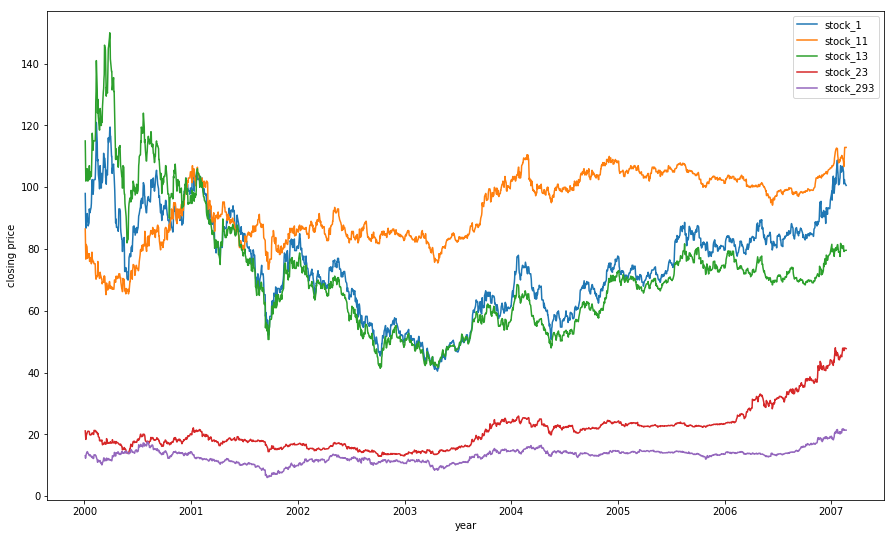

In [42]:
plt.plot(df_stock_1.tdate, df_stock_1.close,label = 'stock_1')
plt.plot(df_stock_11.tdate, df_stock_11.close,label = 'stock_11')
plt.plot(df_stock_13.tdate, df_stock_13.close,label = 'stock_13')
plt.plot(df_stock_23.tdate, df_stock_23.close,label = 'stock_23')
plt.plot(df_stock_293.tdate, df_stock_293.close,label = 'stock_293')
plt.xlabel("year")
plt.ylabel("closing price")
plt.legend(loc='upper right')


In [35]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "open", "high", "low", and "close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["open", "high", "low", "close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                            "high": max(group.high),
                                            "low": min(group.low),
                                            "close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"open": [], "high": [], "low": [], "close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"open": group.iloc[0,0],
                                        "high": max(group.high),
                                        "low": min(group.low),
                                        "close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["open"].tolist(), plotdat["high"].tolist(),
                      plotdat["low"].tolist(), plotdat["close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [36]:
test = pd.concat([df_stock_1.tdate,df_stock_1.open, df_stock_1.high, df_stock_1.low, df_stock_1.close],axis=1)
test2 = test.set_index('tdate')
s1 = df_stock_1.set_index('tdate')
s11 = df_stock_11.set_index('tdate')
s13 = df_stock_13.set_index('tdate')
s23 = df_stock_23.set_index('tdate')
s293 = df_stock_293.set_index('tdate')
test2.head()

,open,high,low,close
tdate,,,,
2000-01-04,100.0,101.0,98.00,98.00
2000-01-05,93.5,95.0,90.75,91.25
2000-01-06,92.0,92.5,85.00,86.75
2000-01-07,88.0,89.0,86.50,88.50
2000-01-10,91.5,93.0,89.25,89.25


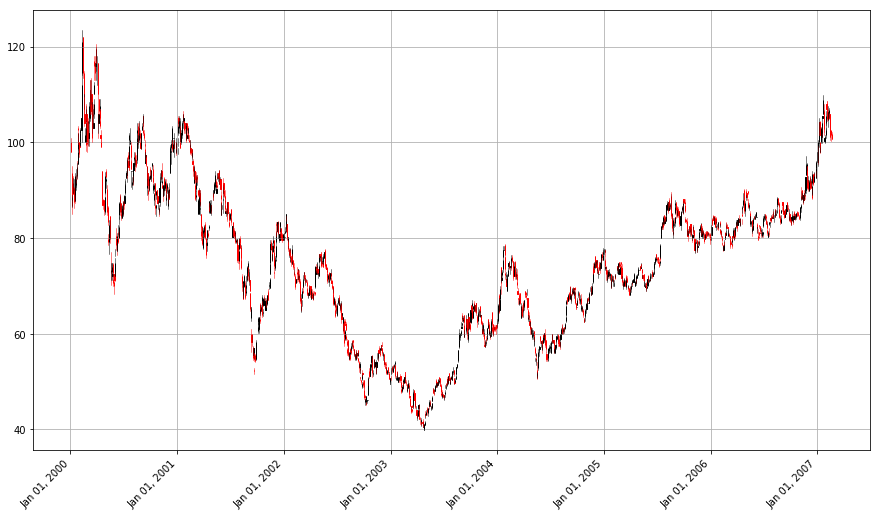

In [37]:
pandas_candlestick_ohlc(test2)

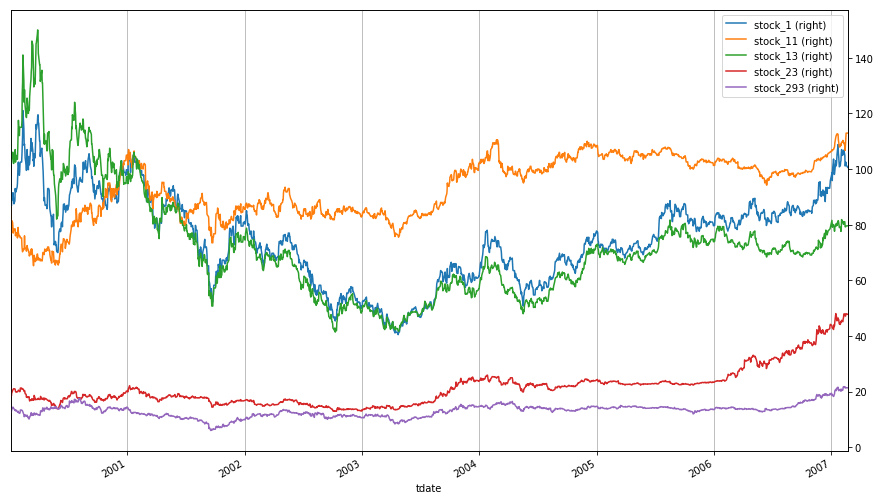

In [41]:
stocks = pd.DataFrame({"stock_1": s1["close"],
                       "stock_11": s11["close"],
                       "stock_13": s13["close"],
                       "stock_23": s23["close"],
                       "stock_293": s293["close"]
})
stocks.plot(secondary_y = ["stock_1","stock_11","stock_13","stock_23", "stock_293"], grid = True)

#For long term, We can find that stock_1 & Stock13 are associated, most stock_1 up then stock_13 up.